In [3]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime
import polars as pl
from collections import defaultdict
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import matplotlib.pyplot as plt

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)


def read_preskladane_data(file_path: str, schema: pl.Schema) -> pl.DataFrame:
    return pl.read_csv(
        file_path,
        null_values=["NA", ""],
        schema=schema,
    )

In [4]:
@dataclass
class Prescription:
    date: datetime
    latka: str
    equiv_sloucenina: str | None
    prednison_equiv: float | None


class Gender(StrEnum):
    MALE = "male"
    FEMALE = "female"


@dataclass
class Person:
    id: int | str
    gender: Gender
    born_at: datetime | None
    vaccines: list[datetime]
    prescriptions: list[Prescription]
    died_at: datetime | None = None


def create_birth_date(year: int, month: int | None) -> datetime | None:
    if year is None:
        return None

    month = month if month is not None else 1
    return datetime(year, month, 1)


def df_to_persons(df: pl.DataFrame) -> list[Person]:
    persons = []

    # Get unique person info efficiently
    try:
        person_info = df.group_by(SHARED_COLUMNS.ID_POJISTENCE.value).agg(
            [
                pl.first(SHARED_COLUMNS.POHLAVI.value).alias("gender"),
                pl.first(SHARED_COLUMNS.ROK_NAROZENI.value).alias("birth_year"),
                pl.first(CPZP_COLUMNS.MESIC_NAROZENI.value).alias("birth_month"),
                pl.first(SHARED_COLUMNS.DATUM_UMRTI.value).alias("death_date"),
            ]
        )
    except Exception as _e:
        person_info = df.group_by(SHARED_COLUMNS.ID_POJISTENCE.value).agg(
            [
                pl.first(SHARED_COLUMNS.POHLAVI.value).alias("gender"),
                pl.first(SHARED_COLUMNS.ROK_NAROZENI.value).alias("birth_year"),
                pl.first(SHARED_COLUMNS.DATUM_UMRTI.value).alias("death_date"),
            ]
        )

    # Get prescriptions efficiently
    prescriptions_df = (
        df.filter(pl.col(SHARED_COLUMNS.TYP_UDALOSTI.value) == TYP_UDALOSTI.PREDPIS)
        .filter(pl.col(SHARED_COLUMNS.DATUM_UDALOSTI.value).is_not_null())
        .group_by(SHARED_COLUMNS.ID_POJISTENCE.value)
        .agg(
            [
                pl.col(SHARED_COLUMNS.DATUM_UDALOSTI.value).alias("prescription_dates"),
                pl.col(SHARED_COLUMNS.LECIVE_LATKY.value).alias("latka"),
                pl.col(SHARED_COLUMNS.EQUIV_SLOUCENINA.value).alias("equiv_sloucenina"),
                pl.col(SHARED_COLUMNS.PREDNISON_EQUIV.value).alias("prednison_equiv"),
            ]
        )
    )

    # Get vaccinations efficiently
    vaccines_df = (
        df.filter(pl.col(SHARED_COLUMNS.TYP_UDALOSTI.value) == TYP_UDALOSTI.VAKCINACE)
        .filter(pl.col(SHARED_COLUMNS.DATUM_UDALOSTI.value).is_not_null())
        .group_by(SHARED_COLUMNS.ID_POJISTENCE.value)
        .agg([pl.col(SHARED_COLUMNS.DATUM_UDALOSTI.value).alias("vaccine_dates")])
    )

    # Join all the data together
    combined = person_info.join(
        prescriptions_df, on=SHARED_COLUMNS.ID_POJISTENCE.value, how="left"
    ).join(vaccines_df, on=SHARED_COLUMNS.ID_POJISTENCE.value, how="left")

    # Convert to Person objects
    for row in combined.iter_rows(named=True):
        person_id = row[SHARED_COLUMNS.ID_POJISTENCE.value]

        # Convert gender
        gender_code = row["gender"]
        gender = Gender.MALE if gender_code == "M" else Gender.FEMALE

        # Create birth date
        birth_year = row["birth_year"]
        birth_month = row.get("birth_month", None)
        born_at = create_birth_date(birth_year, birth_month)

        # Death date
        died_at = row["death_date"]

        # Process prescriptions
        prescriptions = []
        prescription_dates = row["prescription_dates"] or []
        latka = row["latka"] or []
        equiv_sloucenina = row["equiv_sloucenina"] or []
        prednison_equiv = row["prednison_equiv"] or []

        for i, date in enumerate(prescription_dates):
            prescriptions.append(
                Prescription(
                    date=date,
                    latka=latka[i],
                    equiv_sloucenina=equiv_sloucenina[i],
                    prednison_equiv=prednison_equiv[i],
                )
            )

        # Process vaccines
        vaccines = row["vaccine_dates"] or []

        # Create Person object
        person = Person(
            id=person_id,
            gender=gender,
            born_at=born_at,
            vaccines=list(vaccines),
            prescriptions=prescriptions,
            died_at=died_at,
        )

        persons.append(person)

    return persons

In [5]:
cpzp_df = read_preskladane_data("./DATACON_data/CPZP_preskladane.csv", CPZP_SCHEMA)
ozp_df = read_preskladane_data("./DATACON_data/OZP_preskladane.csv", OZP_SCHEMA)
cpzp_persons = df_to_persons(cpzp_df)
ozp_persons = df_to_persons(ozp_df)

In [15]:
persons = sorted(cpzp_persons, key=lambda p: p.id)
dead_persons = [p for p in persons if p.died_at and p.vaccines]

dead_indexes_map = {
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {},
}

first_prescription_from_first_dose_map = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {},
}

first_prescription_map_no_vax_segregation = {}

first_prescription_map_vax_segregation = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {},
}


for p in dead_persons:
    last_vax_date = p.vaccines[-1] if p.vaccines else None
    if last_vax_date:
        days_after_last_vax = (p.died_at - last_vax_date).days
        if days_after_last_vax not in dead_indexes_map[len(p.vaccines)]:
            dead_indexes_map[len(p.vaccines)][days_after_last_vax] = 1
        else:
            dead_indexes_map[len(p.vaccines)][days_after_last_vax] += 1


def find_closest_date(target_date: datetime, dates: list[datetime]):
    if not dates:
        return None
    return max(dates, key=lambda d: abs(target_date - d))


for p in persons:
    first_prescription_date = p.prescriptions[0].date if p.prescriptions else None
    first_vax_date = p.vaccines[0] if p.vaccines else None
    if first_prescription_date and first_vax_date:
        closest_vax_date = (
            find_closest_date(first_prescription_date, p.vaccines)
            if p.vaccines
            else None
        )

        days_after_first_prescription = (first_vax_date - first_prescription_date).days
        if (
            days_after_first_prescription
            not in first_prescription_map_no_vax_segregation
        ):
            first_prescription_map_no_vax_segregation[days_after_first_prescription] = 1
        else:
            first_prescription_map_no_vax_segregation[
                days_after_first_prescription
            ] += 1

        if (
            days_after_first_prescription
            not in first_prescription_from_first_dose_map[len(p.vaccines)]
        ):
            first_prescription_from_first_dose_map[len(p.vaccines)][
                days_after_first_prescription
            ] = 1
        else:
            first_prescription_from_first_dose_map[len(p.vaccines)][
                days_after_first_prescription
            ] += 1

        if closest_vax_date:
            days_after_closest_vax = (closest_vax_date - first_prescription_date).days
            if (
                days_after_closest_vax
                not in first_prescription_map_vax_segregation[len(p.vaccines)]
            ):
                first_prescription_map_vax_segregation[len(p.vaccines)][
                    days_after_closest_vax
                ] = 1
            else:
                first_prescription_map_vax_segregation[len(p.vaccines)][
                    days_after_closest_vax
                ] += 1

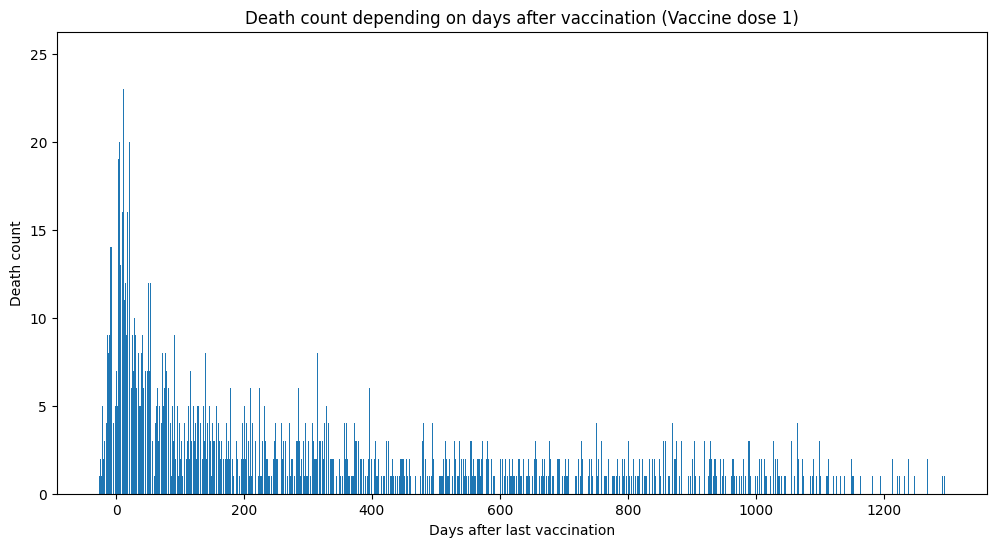

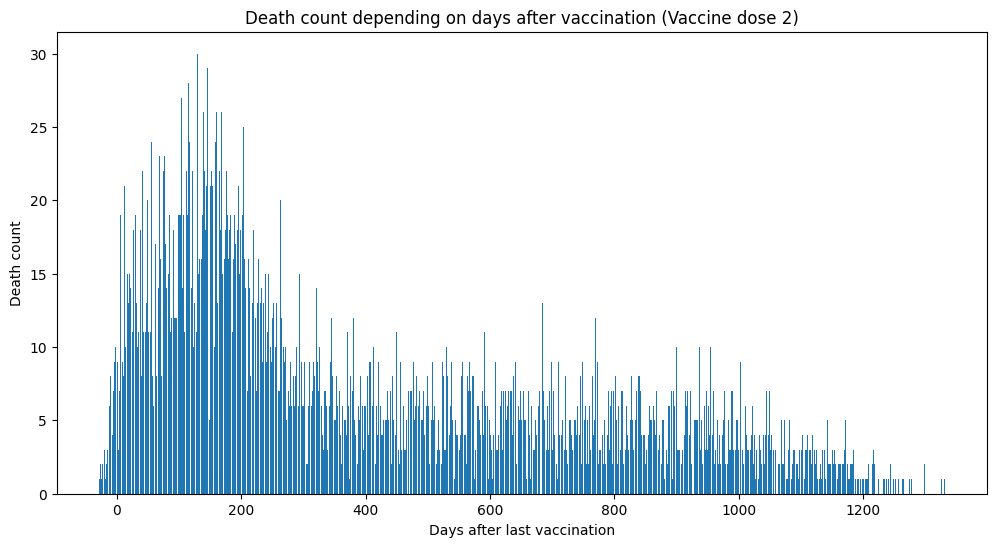

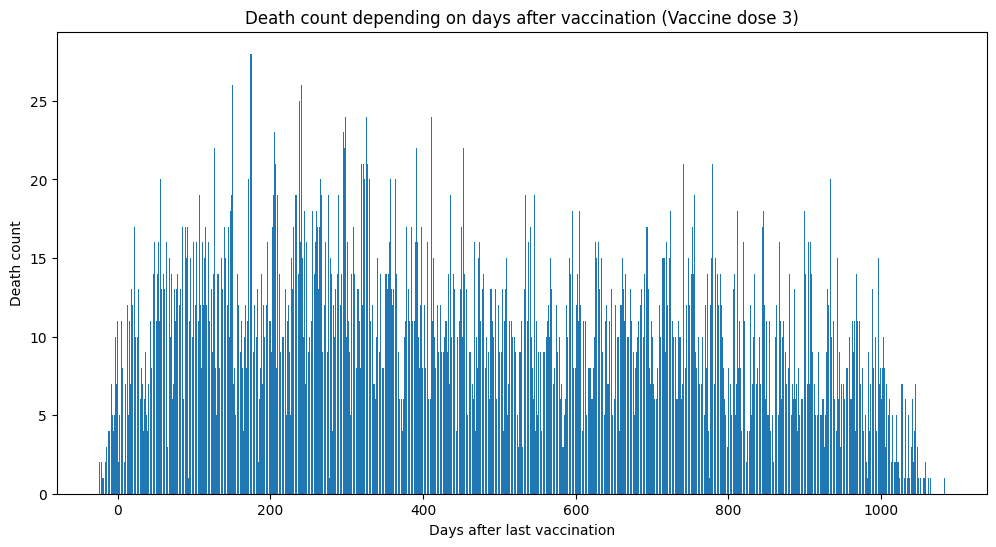

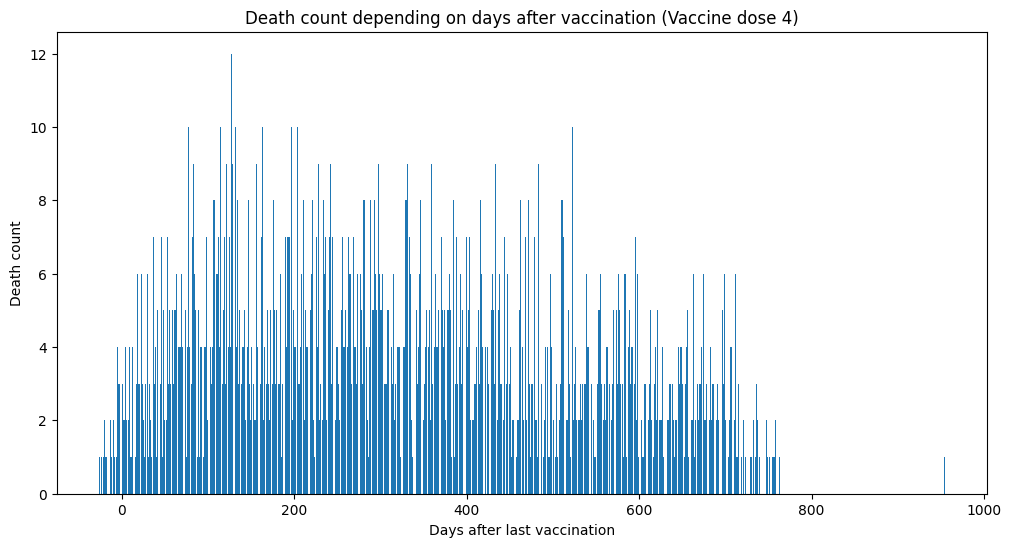

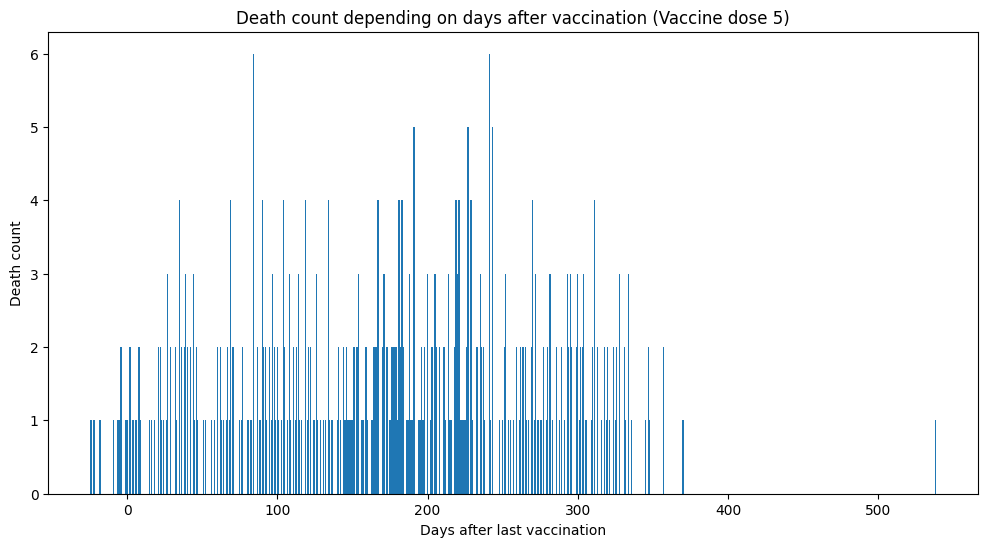

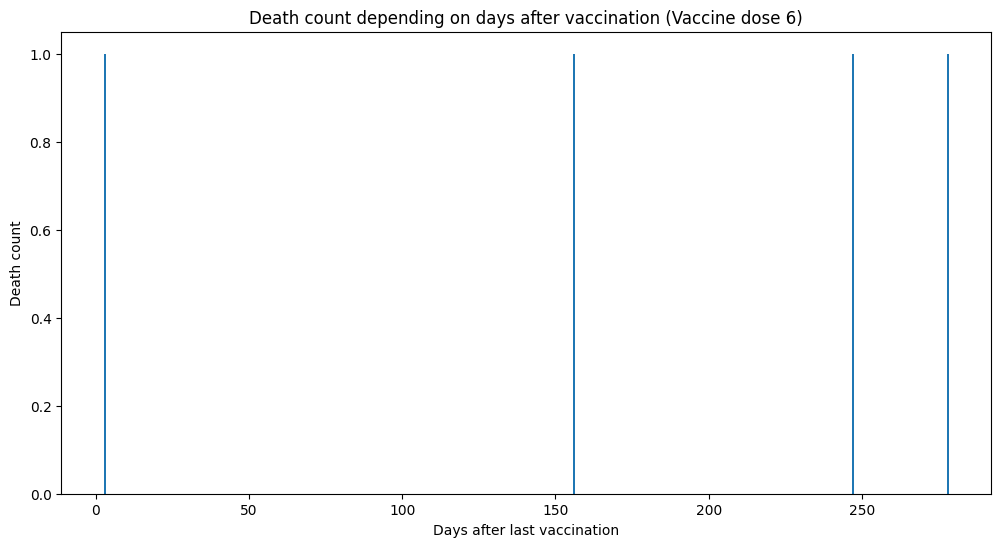

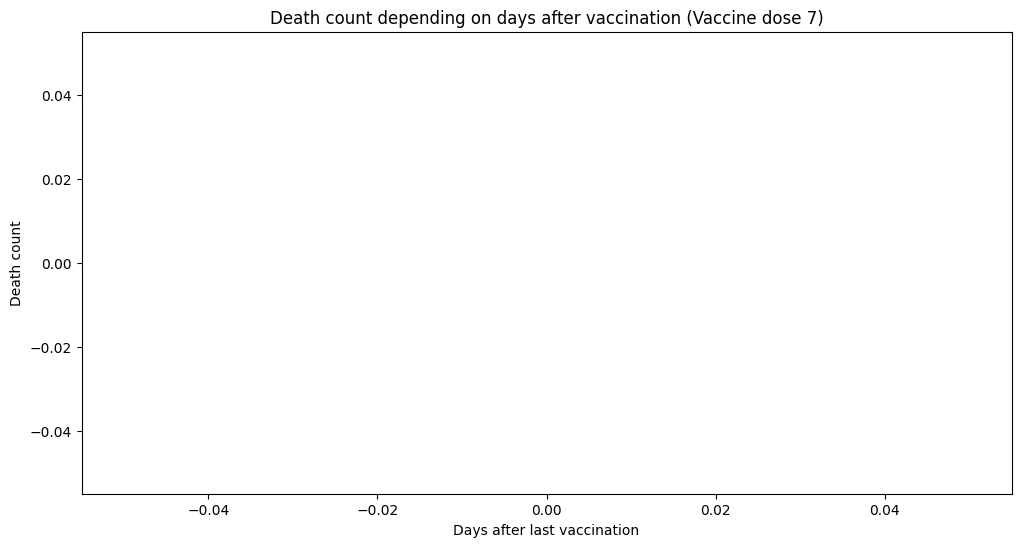

In [8]:
for vaccine_amount, indexes_map in dead_indexes_map.items():
    days_after_last_vax = list(indexes_map.keys())
    first_prescription_counts = list(indexes_map.values())

    plt.figure(figsize=(12, 6))
    plt.bar(days_after_last_vax, first_prescription_counts)

    plt.xlabel("Days after last vaccination")
    plt.ylabel("Death count")
    plt.title(
        f"Death count depending on days after vaccination (Vaccine dose {vaccine_amount})"
    )
    plt.show()

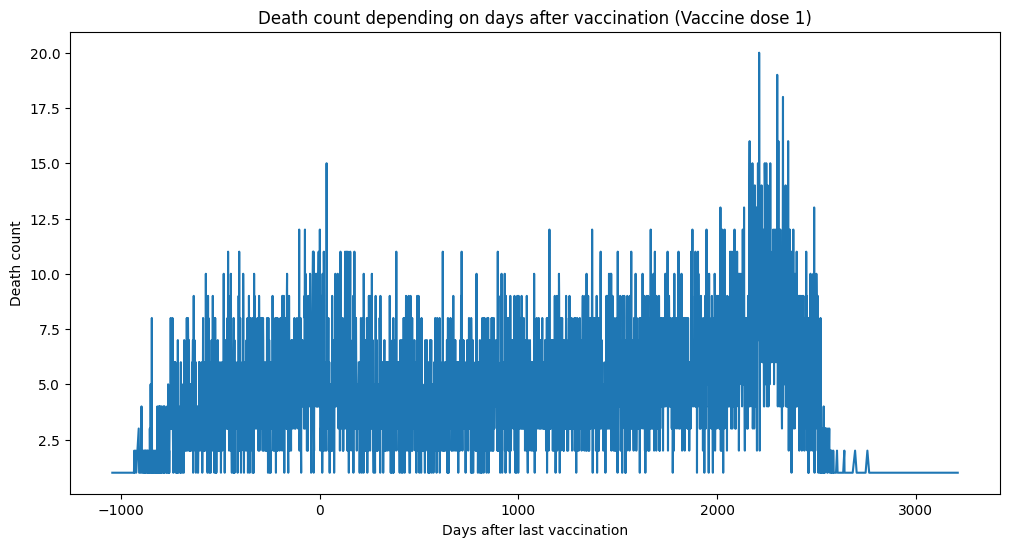

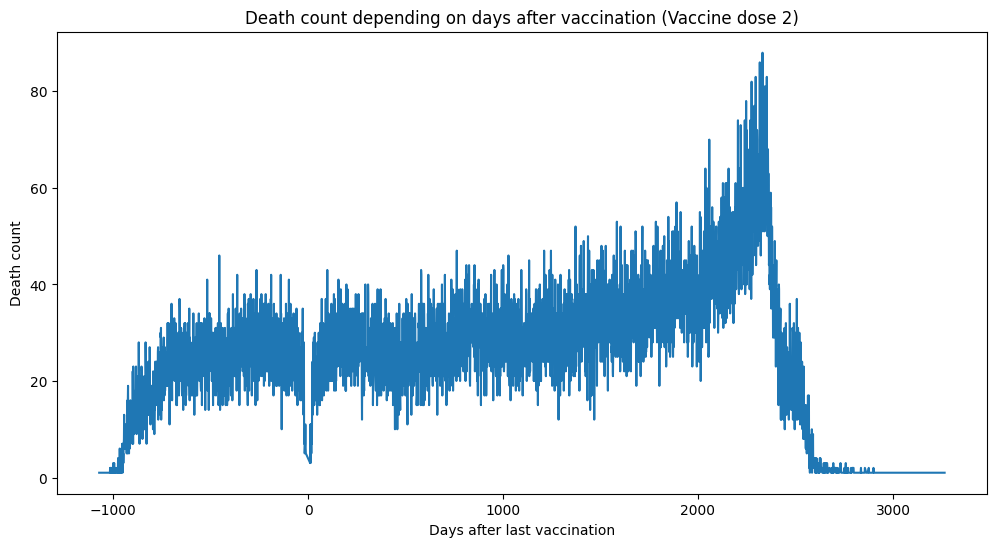

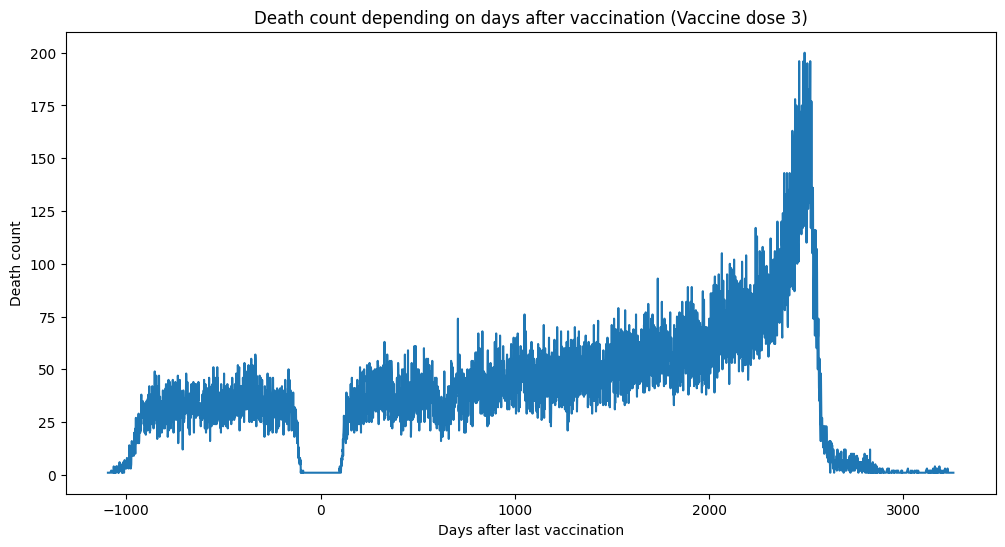

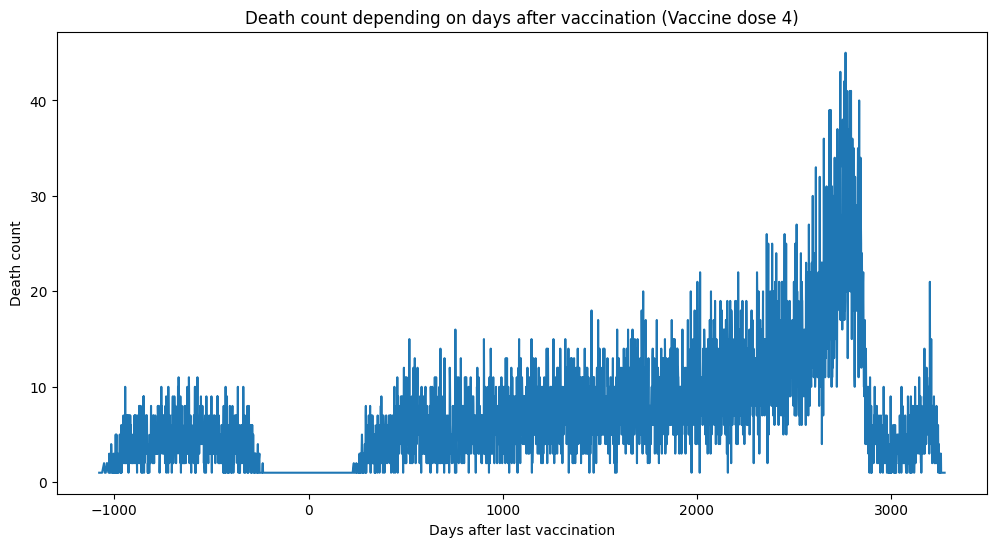

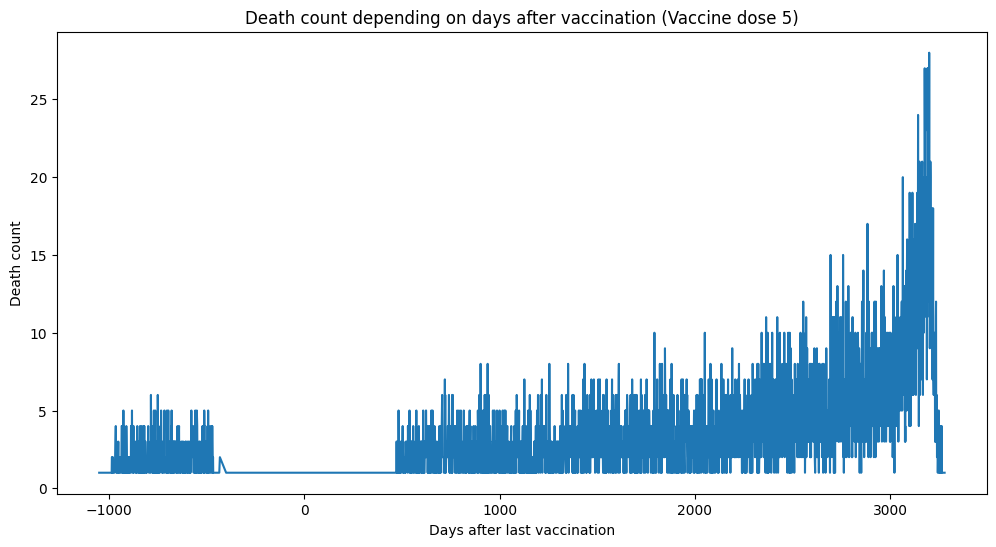

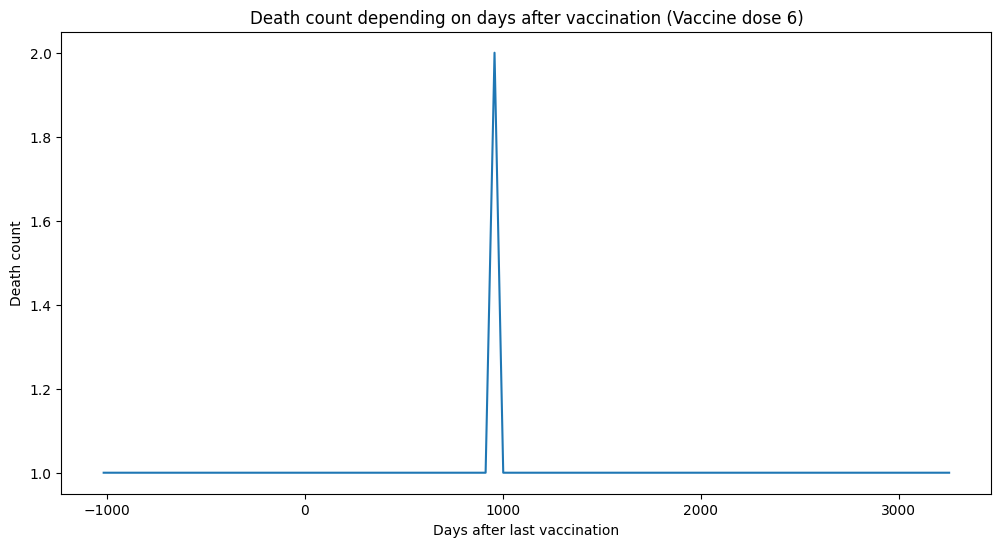

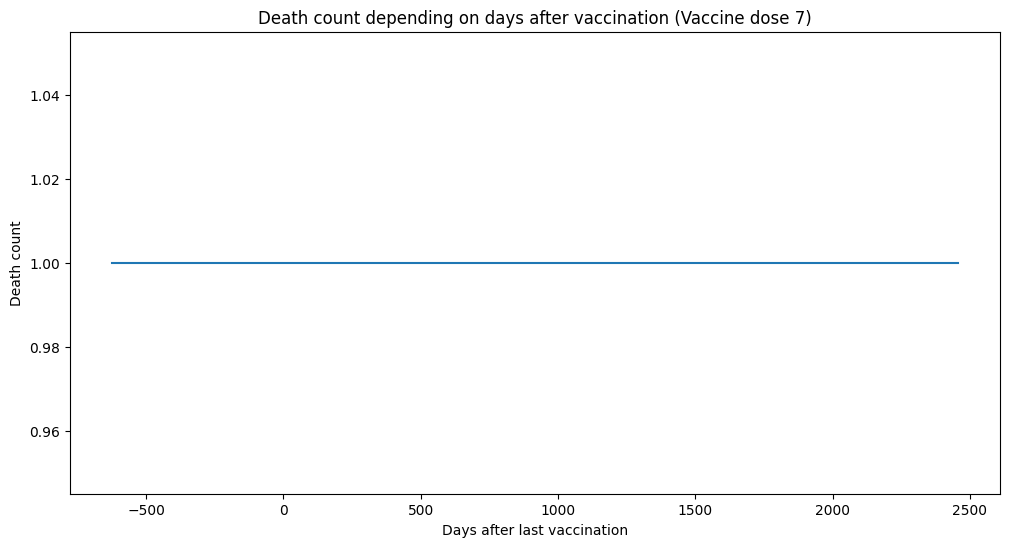

In [ ]:
for vaccine_amount, indexes_map in first_prescription_map_vax_segregation.items():
    days_after_last_vax = list(indexes_map.keys())
    first_prescription_counts = list(indexes_map.values())
    if not days_after_last_vax or not first_prescription_counts:
        continue
    sorted_days_after_last_vax, sorted_first_prescription_counts = zip(
        *sorted(zip(days_after_last_vax, first_prescription_counts))
    )

    plt.figure(figsize=(12, 6))
    plt.plot(sorted_days_after_last_vax, sorted_first_prescription_counts)

    plt.xlabel("Days after last vaccination")
    plt.ylabel("Number of first prescriptions")
    plt.title(
        f"Number of first prescriptions depending on days after vaccination (Vaccine dose {vaccine_amount})"
    )
    plt.show()

{0: {}, 1: {1946: 8, 2208: 9, 1571: 6, -625: 6, 2267: 7, 2065: 7, 2290: 10, 1651: 4, 6: 9, -33: 7, 1792: 4, 2520: 2, 439: 5, 2820: 1, -652: 5, 1022: 6, 729: 3, -66: 4, 1680: 10, 2358: 16, 1199: 5, -144: 6, 1676: 3, 1847: 6, 2403: 9, 182: 8, 2246: 10, 822: 7, 2227: 11, 2025: 9, 1696: 7, 515: 3, 897: 2, 1902: 8, -266: 8, 1513: 7, -733: 6, 1300: 4, 2326: 4, 2015: 6, 1812: 6, 1504: 8, 2209: 12, 2198: 13, 294: 5, 1425: 4, 2170: 8, 2318: 12, 1394: 9, 2345: 14, -638: 1, 1320: 5, 1632: 6, 1786: 5, 1269: 3, 1889: 9, -806: 1, -169: 3, 1568: 11, 1806: 11, 160: 3, -687: 3, -304: 2, 91: 8, 937: 9, 135: 3, 857: 3, -830: 2, -720: 4, 806: 7, 1280: 3, 221: 10, 1301: 5, 1608: 5, 1205: 9, 309: 6, -465: 8, -165: 10, -694: 3, -644: 5, 343: 5, 1846: 8, -1: 5, 2129: 12, 1627: 3, 1343: 10, 1297: 7, 2207: 7, 153: 11, 558: 4, 330: 3, -306: 9, 1103: 3, 594: 4, 1150: 4, 876: 8, 1358: 5, 2322: 10, 1975: 7, 2353: 11, -454: 6, -71: 6, 98: 7, 2134: 9, 1971: 7, 2177: 4, 383: 5, 1543: 5, 1621: 5, 156: 5, 1759: 8, -502:

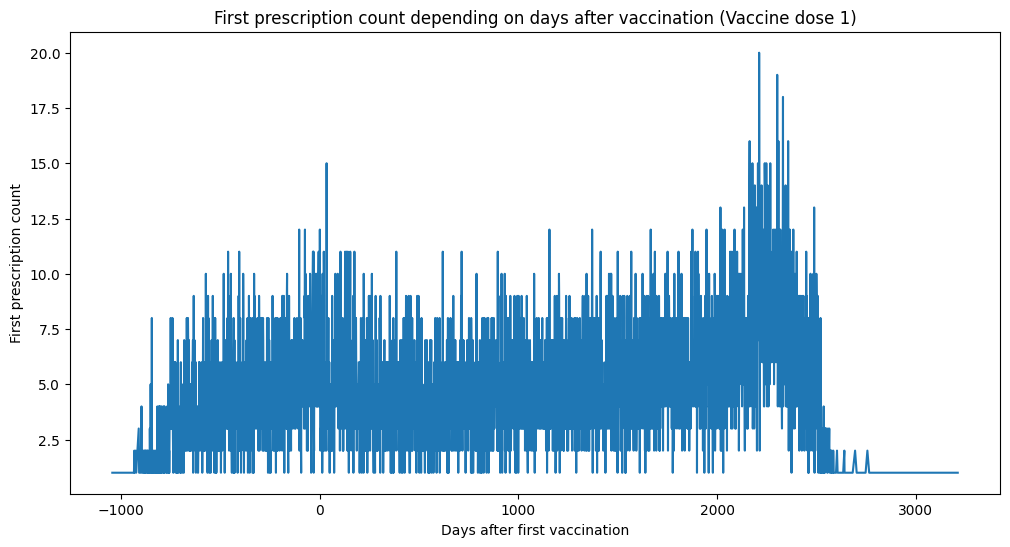

5
9
6


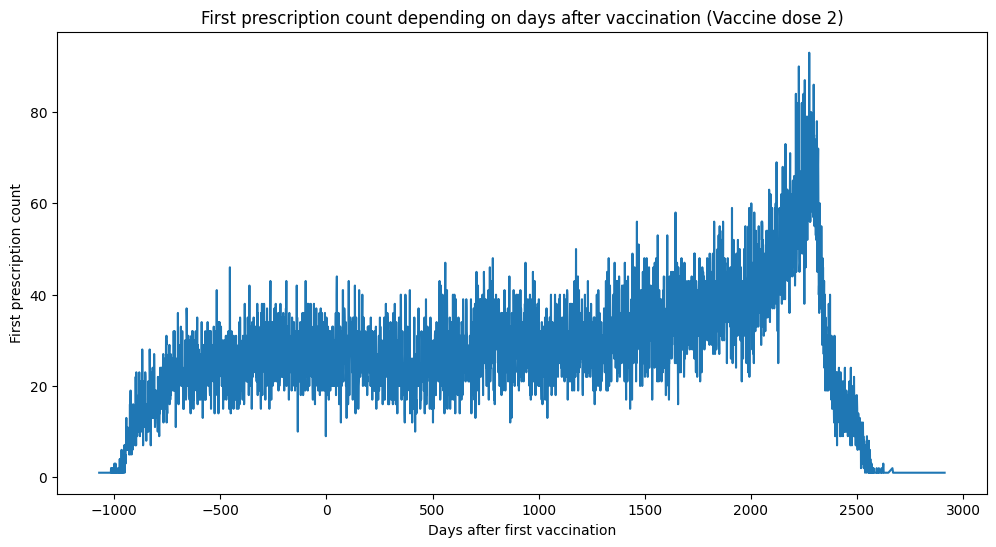

5
9
6


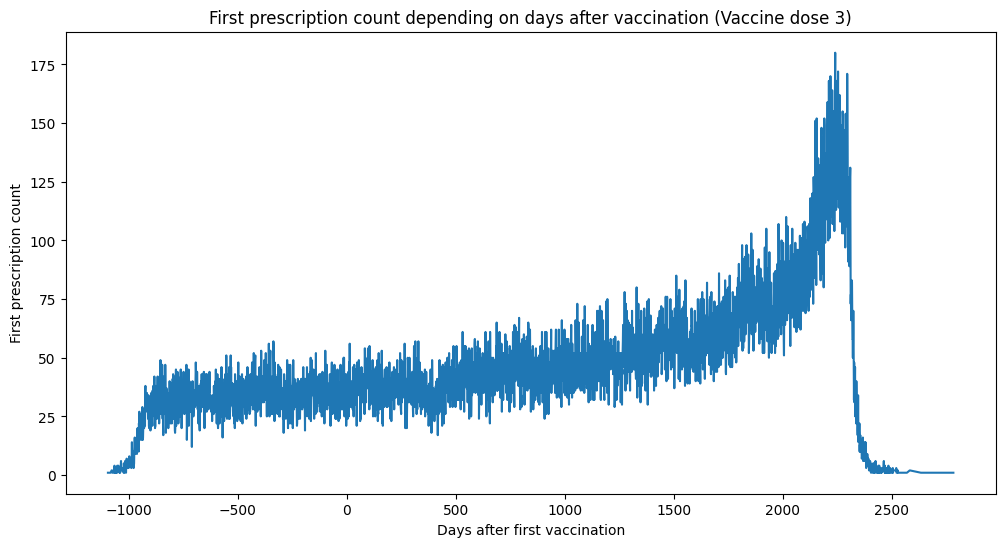

5
9
6


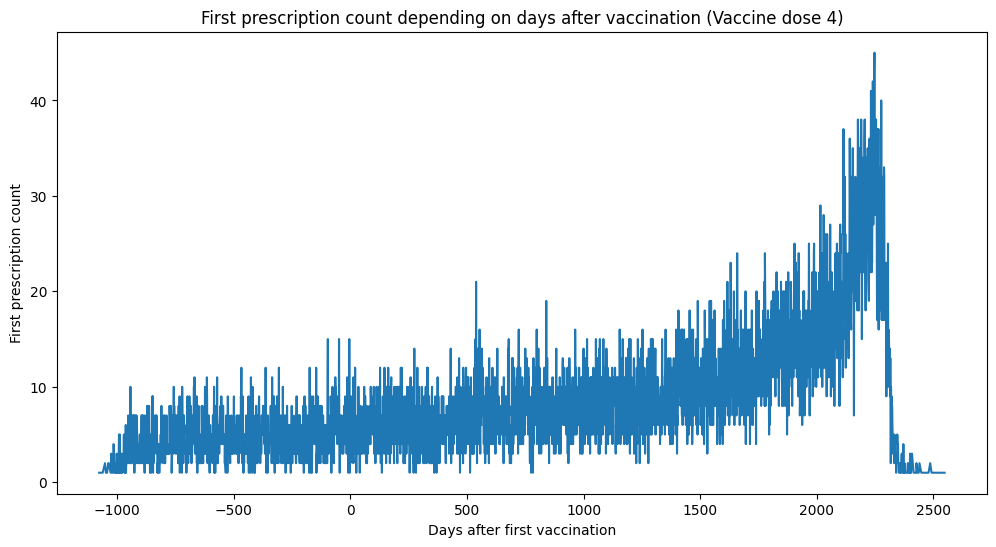

5
9
6


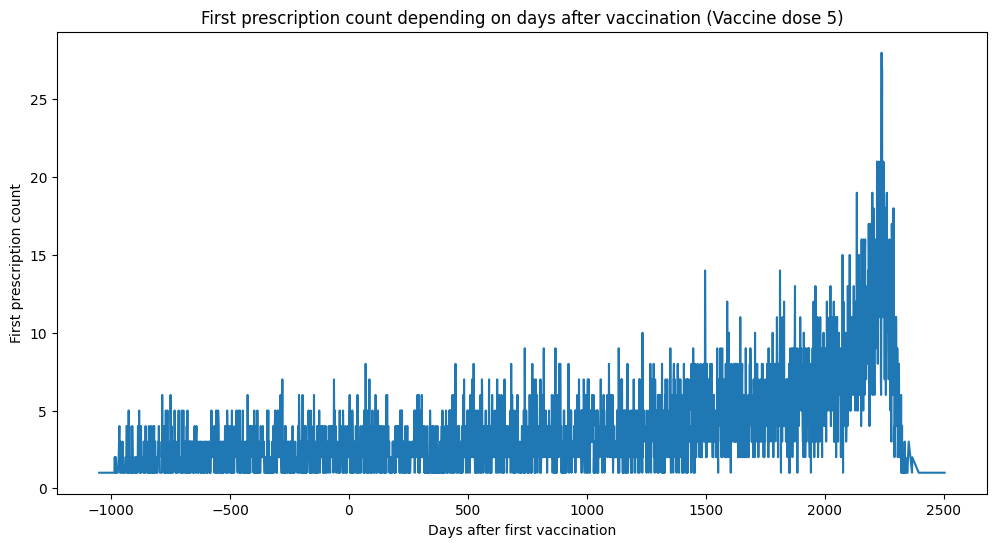

5
9
6


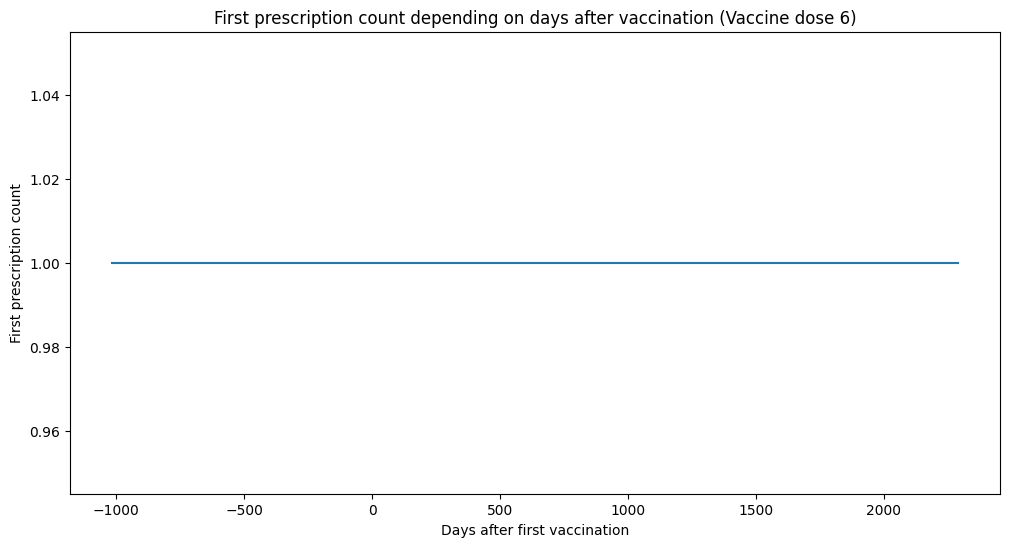

5
9
6


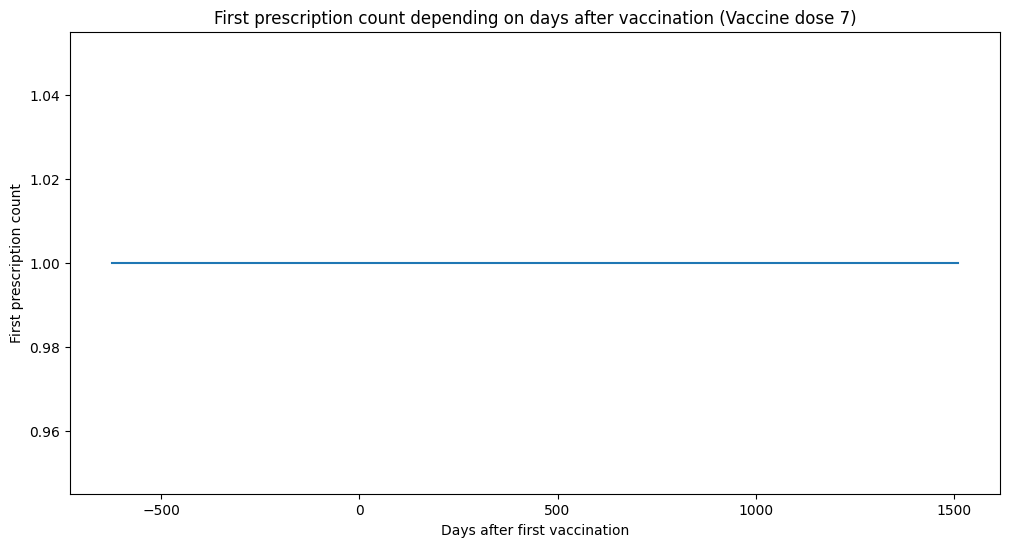

In [ ]:
print(first_prescription_from_first_dose_map)

for vaccine_amount, indexes_map in first_prescription_from_first_dose_map.items():
    days_after_last_vax = list(indexes_map.keys())
    first_prescription_counts = list(indexes_map.values())
    if not days_after_last_vax or not first_prescription_counts:
        continue

    sorted_days_after_last_vax, sorted_first_prescription_counts = zip(
        *sorted(zip(days_after_last_vax, first_prescription_counts))
    )

    plt.figure(figsize=(12, 6))
    plt.plot(sorted_days_after_last_vax, sorted_first_prescription_counts)

    plt.xlabel("Days after first vaccination")
    plt.ylabel("First prescription count")
    plt.title(
        f"First prescription count depending on days after vaccination (Vaccine dose {vaccine_amount})"
    )
    plt.show()

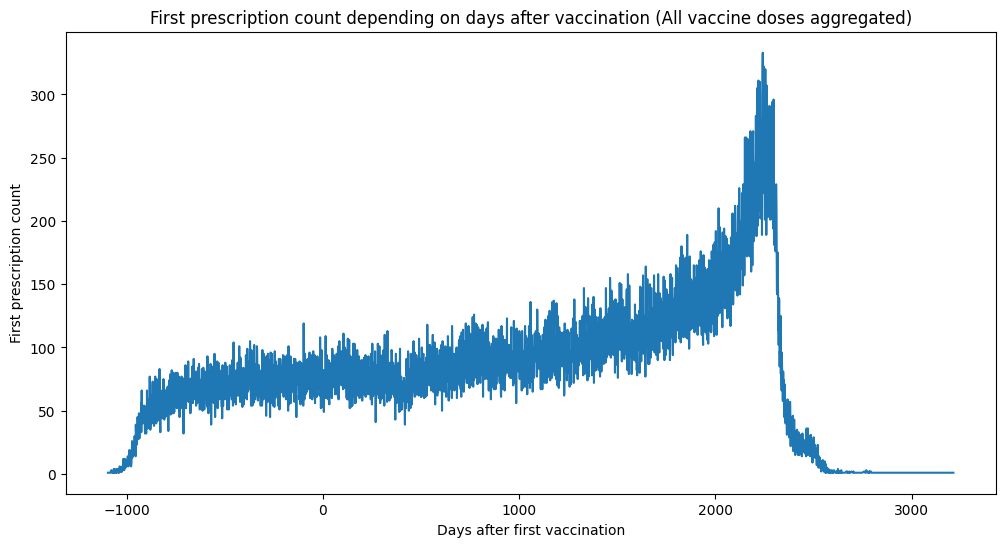

In [ ]:
days_after_last_vax = list(first_prescription_map_no_vax_segregation.keys())
first_prescription_counts = list(first_prescription_map_no_vax_segregation.values())

sorted_days_after_last_vax, sorted_first_prescription_counts = zip(
    *sorted(zip(days_after_last_vax, first_prescription_counts))
)

plt.figure(figsize=(12, 6))
plt.plot(sorted_days_after_last_vax, sorted_first_prescription_counts)

plt.xlabel("Days after first vaccination")
plt.ylabel("First prescription count")
plt.title(
    f"First prescription count depending on days after vaccination (All vaccine doses aggregated)"
)
plt.show()